In [12]:
# ==============================================================
# Notebook 0 (Phase 0)
# WHY THE PSEUDOINVERSE FAILS FOR ILL-POSED INVERSE PROBLEMS
# --------------------------------------------------------------
# This notebook is the *conceptual + numerical foundation*.
# It explicitly demonstrates:
#   y = A x + ε
#   x_pinv = A^+ y  --> unstable
# using a SMALL 16×16 PATCH where A can be built explicitly.
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from numpy.linalg import svd


In [13]:
# --------------------------------------------------------------
# 1. Load FULL image (context only)
# --------------------------------------------------------------
image_path = r"images\296059.jpg"# CHANGE PATH


img = plt.imread(image_path)
if img.ndim == 3:
    img = img.mean(axis=2)


x_full = img.astype(float)
x_full /= x_full.max()


print("Full image shape:", x_full.shape)

Full image shape: (321, 481)


In [14]:
# --------------------------------------------------------------
# 2. Gaussian blur kernel (forward operator)
# --------------------------------------------------------------
def gaussian_kernel(size=9, sigma=2.0):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel


kernel = gaussian_kernel(size=9, sigma=2.0)

In [15]:
# 3. Extract a 16×16 PATCH (diagnostic only)
# --------------------------------------------------------------
patch = x_full[100:116, 100:116]
patch /= patch.max()


n = patch.shape[0]
assert patch.shape == (16, 16), "Patch must be 16×16"

In [16]:
# --------------------------------------------------------------
# 4. Build EXPLICIT convolution matrix A (16×16 ONLY)
# --------------------------------------------------------------
def build_convolution_matrix(kernel, patch_size):
    N = patch_size * patch_size
    A = np.zeros((N, N))


    for i in range(N):
        basis = np.zeros((patch_size, patch_size))
        basis.flat[i] = 1.0
        conv = convolve2d(basis, kernel, mode="same", boundary="symm")
        A[:, i] = conv.flatten()


    return A


A = build_convolution_matrix(kernel, n)
print("Explicit A shape:", A.shape)

Explicit A shape: (256, 256)


In [17]:
# --------------------------------------------------------------
# 5. Forward model on patch: y = A x + ε
# --------------------------------------------------------------
Ax_patch = convolve2d(patch, kernel, mode="same", boundary="symm")


noise_std = 0.01
eps = noise_std * np.random.randn(*Ax_patch.shape)
y_patch = Ax_patch + eps


x_vec = patch.flatten()
y_vec = y_patch.flatten()

In [18]:
# --------------------------------------------------------------
# 6. Singular Value Decomposition of A
# --------------------------------------------------------------
U, S, Vt = svd(A, full_matrices=False)


print("Condition number of A:", S[0] / S[-1])

Condition number of A: 58710328.427196175


In [19]:
# --------------------------------------------------------------
# 7. Moore–Penrose pseudoinverse reconstruction
# --------------------------------------------------------------
S_inv = np.diag(1.0 / S)
x_pinv = Vt.T @ S_inv @ U.T @ y_vec
x_pinv_img = x_pinv.reshape(patch.shape)

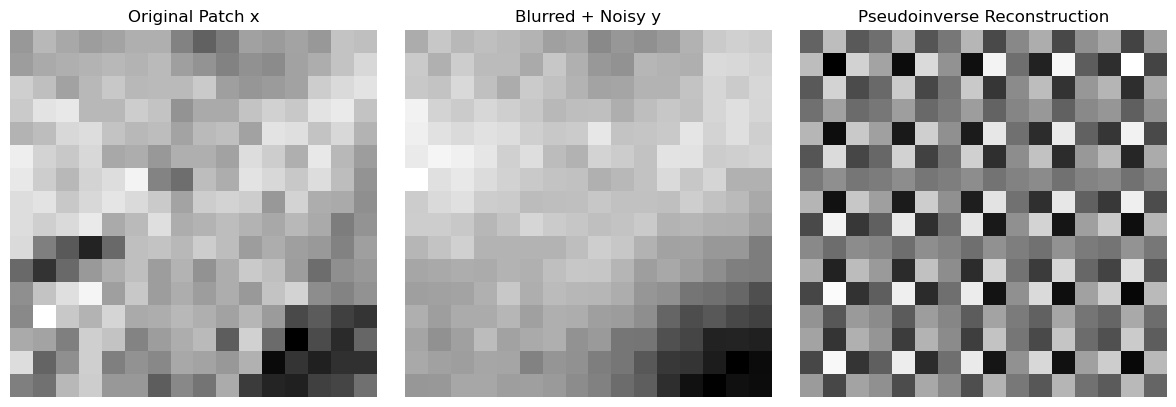

In [20]:
# --------------------------------------------------------------
# 8. Visual comparison
# --------------------------------------------------------------
plt.figure(figsize=(12,4))


plt.subplot(1,3,1)
plt.imshow(patch, cmap="gray")
plt.title("Original Patch x")
plt.axis("off")


plt.subplot(1,3,2)
plt.imshow(y_patch, cmap="gray")
plt.title("Blurred + Noisy y")
plt.axis("off")


plt.subplot(1,3,3)
plt.imshow(x_pinv_img, cmap="gray")
plt.title("Pseudoinverse Reconstruction")
plt.axis("off")


plt.tight_layout()
plt.show()

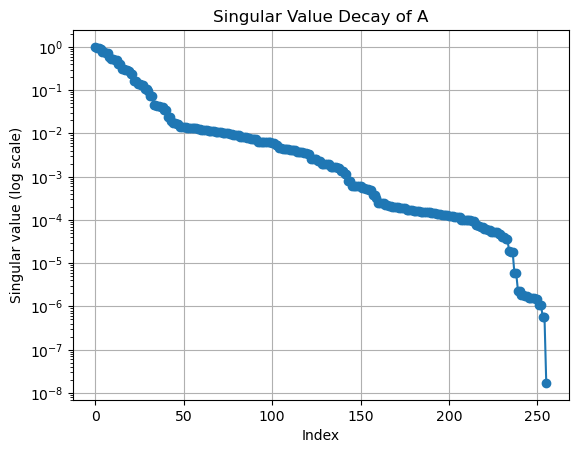

In [21]:
# --------------------------------------------------------------
# 9. Singular value decay (root cause)
# --------------------------------------------------------------
plt.figure()
plt.semilogy(S, 'o-')
plt.xlabel("Index")
plt.ylabel("Singular value (log scale)")
plt.title("Singular Value Decay of A")
plt.grid(True)
plt.show()

In [22]:
# --------------------------------------------------------------
# 10. Quantitative instability evidence
# --------------------------------------------------------------
rel_error = np.linalg.norm(x_pinv_img - patch) / np.linalg.norm(patch)
print("Relative reconstruction error (pseudoinverse):", rel_error)

Relative reconstruction error (pseudoinverse): 43824.619555306985
